In [1]:
import sys

# Add the parent directory to the system path
sys.path.append("../04_survival_models/src")

In [2]:
import json
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from azureml.core import Dataset, Datastore, Workspace
from scipy import stats
from uc2_functions import *
from tqdm import tqdm
import csv

In [3]:
# Suppress warnings from scipy
warnings.filterwarnings("ignore", category=UserWarning, module="scipy")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="scipy")

# Goal

The goal is to preprocess the data and prepare it for machine learning modeling.

# Parameters

In [4]:
# Legend
PATH_LEGEND = "Legenda_Variabili_Uri_Larcher.xlsx"
# Directories
DIR_SC = os.path.join(os.path.dirname(os.getcwd()), "sc")  # Legend

# Data ingestion

## `Dataset` srace_urologia_nonmeta_q1_all_survival

In [5]:
subscription_id = "753a0b42-95dc-4871-b53e-160ceb0e6bc1"
resource_group = "rg-s-race-aml-dev-we"
workspace_name = "amlsraceamldevwe01"

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name="srace_urologia_nonmeta_q1_all_survival")
df_all = dataset.to_pandas_dataframe()
print(df_all.shape)
df_all.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
(3081, 7056)


,index,P_1_id,isalive,censor,__index_level_0___x,Column1,P_1_sex,P_1_exitusState,P_1_exitusDate,P_1_exitusCause,...,gfr_108_EPI,gfr_108_BIS,gfr_108,gfr_120_EPI,gfr_120_BIS,gfr_120,yob,delta_secondo_tumore_mesi,num_int_doc,__index_level_0___y
0,0,1,True,False,0,1,M,Si,13512960000,None,...,None,None,None,None,None,None,1918,NaN,2,0
1,1,2,False,False,1,2,F,Si,13081824000,Altracausa,...,None,None,None,None,None,None,1945,NaN,32,1
2,2,4,True,False,2,3,M,Si,13340160000,None,...,None,None,None,None,None,None,1925,NaN,7,2
3,3,5,True,False,3,4,F,No,None,None,...,None,None,None,67.0108377500802,66.7416388846908,67.01,1949,NaN,346,3
4,4,6,True,False,4,5,M,No,None,None,...,None,None,None,None,None,None,1952,NaN,430,4


## `.xlsx` Legend

In [6]:
df_legend = pd.read_excel(
    os.path.join(DIR_SC, PATH_LEGEND), sheet_name="Legenda Urologi - DB Larcher"
)
# Replace dot with underscore
df_legend["Variable"] = df_legend["Variable"].apply(lambda x: x.replace(".", "_"))
# Forward fill domain
df_legend["Domain"] = df_legend["Domain"].fillna(method="ffill")
df_legend.head()

/tmp/ipykernel_23926/3866169337.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_legend["Domain"] = df_legend["Domain"].fillna(method="ffill")


,Domain,Variable,Definition,Unit/Interpretation,Notes
0,clinical history,id,patient identification string,patient identification string,NaN
1,clinical history,dob,date of birth,yyyy-mm-dd,NaN
2,clinical history,age,age at treatment,years,NaN
3,clinical history,sex,gender,"M ""Male""; F ""Female""",NaN
4,clinical history,bmi,body mass index,kg/m2,NaN


### Create dictionary

In [7]:
dict_legend = pd.Series(
    df_legend["Definition"].values, index=df_legend["Variable"]
).to_dict()

# Cast empty cells as np.nan

In [8]:
df_all = (
    df_all.replace("NaN", np.nan)
    .replace("NA", np.nan)
    .replace("None", np.nan)
    .replace("nan", np.nan)
)

# Feature selection

## Target variables

In [9]:
print(df_all["acm"].equals(df_all["death"]))

True


`acm` and `death` are identical: we'll use `death`.

In [10]:
print(df_all["ttacm"].equals(df_all["ttdeath"]))
print(df_all["ttcsm"].equals(df_all["ttdeath"]))
print(df_all["ttocm"].equals(df_all["ttdeath"]))

True
True
True


All time to event columns are identical: we'll use `ttdeath`.

Both `ocm` and `csm` True should be impossible:

In [11]:
assert df_all[(df_all["ocm"] == True) & (df_all["csm"] == True)].shape[0] == 0

In [12]:
col_target = ["death", "csm", "ocm", "ttdeath"]

## Narrow selection (Larcher columns)

In [13]:
col_raw = df_legend["Variable"].tolist()
col_raw = col_raw + [
    "p_transfusion_unit",
    "hf",
    "ami",
    "hf",
    "cerebrovd",
    "i_transfusion_unit",
    "pT",
    "pN",
    "p_transfusion_unit",
]
print(len(col_raw))

133


### Columns from `df_legend` not in `df_all`

Some columns are in the legend but not in the actual dataframe (pseudo-anonymized), we drop them from the list:

In [14]:
col_raw_anonymous = []
for col in col_raw:
    if col in df_all.columns:
        col_raw_anonymous.append(col)
    else:
        continue
del col_raw
print(len(col_raw_anonymous))

126


### Irrelevant features for ml models

In [15]:
# List of columns to drop
col_drop = ["id", "dos", "yos", "surgeon", "status_a"]
col_drop = (
    col_drop
    + df_legend[df_legend["Domain"] == "functional follow-up"]["Variable"].tolist()
)
col_drop = (
    col_drop
    + df_legend[df_legend["Domain"] == "oncologic follow-up"]["Variable"].tolist()
)

In [16]:
# Drop irrelevant features
col_raw_anonymous = ["P_1_id"] + [
    item
    for item in col_raw_anonymous
    if (item not in col_drop) and (item not in col_target)
]
col_raw_anonymous = sorted(set(col_raw_anonymous))
print(len(col_raw_anonymous))

93


## Select and cast columns of interest

In [17]:
count_columns_by_dtype(df_all[col_raw_anonymous + col_target])

int64: 4
object: 63
float64: 30


In [18]:
# Select and cast columns of interest
caster = DataFrameCaster(df_all[col_raw_anonymous + col_target].copy())
df_selected = caster.infer_and_cast()
print(df_selected.shape)

# Delete df_all
del df_all

(3081, 97)


In [19]:
count_columns_by_dtype(df_selected)

float64: 40
ordinal category: 6
non ordinal category: 23
boolean: 28


In [20]:
print(df_selected.shape)
l = df_selected.columns.tolist()

with open("larcher_preprocess_step1_output_columns.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for col in l:
        writer.writerow([col])
del l

(3081, 97)


# Univariate analysis

We perform univariate analysis as initial feature selection (based on `csm`):

In [21]:
COL_NAME = "col_name"
DTYPE = "dtype"
TST_KIND = "tst_kind"
SIGNIFIC = "signific"
REJECTED = "rejected"

d = {
    COL_NAME: [],
    DTYPE: [],
    TST_KIND: [],
    SIGNIFIC: [],
    REJECTED: [],
}

# Instantiate the feature selector
ufs = UnivariateFeatureSelector(
    df_selected[col_raw_anonymous + ["csm"]], "csm", p_threshold=0.2, verbose=False
)

count = 0
for col in tqdm(df_selected[col_raw_anonymous].columns):
    if (
        df_selected[col].dtype.name == "category"
        or df_selected[col].dtype.name == "boolean"
    ):
        d[COL_NAME].append(col)
        d[DTYPE].append(df_selected[col].dtype.name)
        d[TST_KIND].append("CHISQUARE")
        significance, rejected = ufs.compute_stat_importance_categorical(col)
        d[SIGNIFIC].append(significance)
        d[REJECTED].append(rejected)

    elif df_selected[col].dtype.name == "float64":
        d[COL_NAME].append(col)
        d[DTYPE].append(df_selected[col].dtype.name)
        d[TST_KIND].append("WILCOXON")
        significance, rejected = ufs.compute_stat_importance_numerical(col)
        d[SIGNIFIC].append(significance)
        d[REJECTED].append(rejected if rejected is not None else np.nan)

        d[COL_NAME].append(col)
        d[DTYPE].append(df_selected[col].dtype.name)
        d[TST_KIND].append("T-TEST")
        significance, rejected = ufs.compute_stat_importance_t_test(col)
        d[SIGNIFIC].append(significance)
        d[REJECTED].append(rejected if rejected is not None else np.nan)

    else:
        if ufs.verbose:
            print(
                f"Column {col} has an unsupported data type: {df_selected[col].dtype.name}"
            )

# Create dataframe from dictionary
df_univariate = pd.DataFrame(d)
del d

# Keep column if it is rejected by at least one of the tests
df_univariate["rejected_or_na"] = (
    df_univariate[REJECTED].isna() | df_univariate[REJECTED]
)
df_univariate["keep"] = df_univariate.groupby(COL_NAME)["rejected_or_na"].transform(any)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 40.78it/s]


In [22]:
# List of columns to keep
col_keep = df_univariate[df_univariate["keep"] == True]["col_name"].unique().tolist()
print(len(col_keep))

73


# Split features and target

In [23]:
assert "P_1_id" in col_keep
df_features = df_selected.drop(col_target, axis=1)[col_keep]
print(df_features.shape)
df_target = df_selected[["P_1_id"] + col_target]
print(df_target.shape)
del df_selected

(3081, 73)
(3081, 5)


In [24]:
print(df_features.shape)
l = df_features.columns.tolist()

with open("larcher_preprocess_step2_output_columns.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for col in l:
        writer.writerow([col])
del l

(3081, 73)


# Data selection (remove outliers, balancing for rare events)

[Data scientists and domain experts] Survey data for outliers which may distort the Cox model. Statistically identified outliers should be evaluated by domain experts for scientific relevance. Consider the necessity of balancing for rare events, which may involve merging similar categories. Decisions should leverage both data-driven insight and domain knowledge.

Columns with outliers:
[
    "age   age at treatment",
    "cci   Charlson comorbidy index",
    "p_size   tumor size at histological examination"
]
Columns with rare events:
[
    "asa   American Society of Anestesiologist score",
    "cT   pathological tumour stage",
    "comp_type   postoperative complications type",
    "ecog   Eastern Cooperative Oncology Group performance status",
    "grade   pathological tumour grade",
    "histology   histotype",
    "lesion_number   number of lesions",
    "pN",
    "pT",
    "pos_full   tumour position - full involvement of the kidney",
    "pos_hil   tumour position - hilar",
    "s_sys   systemic symptoms at diagnosis",
    "sarco   sarcomatoid features",
    "treatment   treatment type"
]


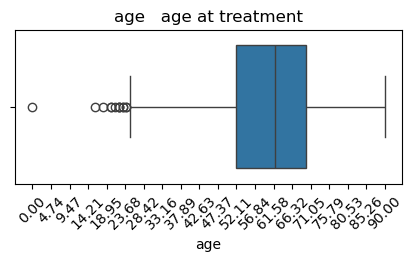

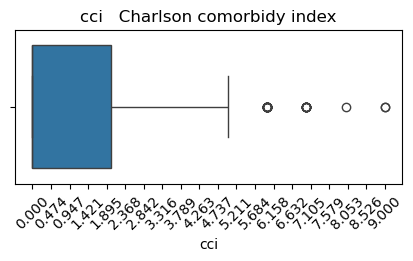

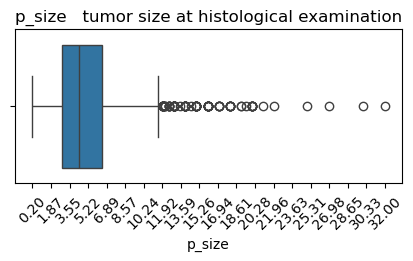

In [25]:
PLOTS_OUTLIERS = True
PLOTS_RARE_EVENTS = False

# Select only numeric columns
df_numeric = df_features.select_dtypes(include=[np.number])

# Calculate z-scores (we're not casting to integers here anymore)
z_scores = np.abs(stats.zscore(df_numeric.astype(float)))

threshold = 3  # common choice for detecting outliers
outliers = (z_scores > threshold).any(axis=0)  # modified to detect per column

# Columns with outliers
cols_with_outliers = df_numeric.columns[outliers]

# Map definitions from dict
print("Columns with outliers:")
print(
    json.dumps(
        [
            f"{x}   {dict_legend.get(x, '')}" if x in dict_legend else x
            for x in cols_with_outliers
        ],
        indent=4,
    )
)

# Detect columns with rare events
rare_threshold = 0.05  # threshold to consider an event as rare
cols_with_rare = [
    col
    for col in df_features.select_dtypes(include=["object", "bool", "category"]).columns
    if (df_features[col].value_counts(normalize=True) < rare_threshold).any()
]

# Map definitions from dict
print("Columns with rare events:")
print(
    json.dumps(
        [
            f"{x}   {dict_legend.get(x, '')}" if x in dict_legend else x
            for x in cols_with_rare
        ],
        indent=4,
    )
)

l = []
figsize = (5, 2)
for col in df_features.columns:
    definition = dict_legend.get(col, "")
    if definition == "":
        l.append(col)
    title = col + "   " + definition

    if (
        df_features[col].dtype in ["int64", float]
        and col in cols_with_outliers
        and PLOTS_OUTLIERS is True
    ):
        plt.figure(figsize=figsize)
        sns.boxplot(x=df_features[col])
        plt.title(title)

        xticks = np.linspace(df_features[col].min(), df_features[col].max(), 20)
        plt.xticks(xticks, rotation=45)

        plt.show()

    elif (
        df_features[col].dtype.name == "category"
        and col in cols_with_rare
        and PLOTS_RARE_EVENTS is True
    ):
        if len(df_features[col].cat.categories) < 10:
            plt.figure(figsize=figsize)
            sns.countplot(x=df_features[col], data=df_features)
            plt.title(title)

            xticks = np.arange(len(df_features[col].cat.categories))
            plt.xticks(xticks, df_features[col].cat.categories, rotation=45)

            plt.show()

    elif (
        df_features[col].dtype == "bool"
        and col in cols_with_rare
        and PLOTS_RARE_EVENTS is True
    ):
        plt.figure(figsize=figsize)
        df_features[col].value_counts().plot(kind="barh", stacked=True)
        plt.title(title)

        yticks = np.arange(len(df_features[col].value_counts().index))
        plt.yticks(yticks, df_features[col].value_counts().index)

        plt.show()

    else:
        continue

### Variable `ANM_1_age`

In [26]:
print(df_features.shape[0])
df_features = df_features[df_features["age"] != 0]
print(df_features.shape[0])

3081
3080


### Variable `bmi`

`bmi` under 10 and over 100 represent clear outliers, we remove them:

In [27]:
# Define thresholds
bmi_lower = 10
bmi_uppuer = 100

# Remove bmi under 10 and over 200
print(df_features.shape[0])
df_features = df_features[
    ((df_features["bmi"] > bmi_lower) & (df_features["bmi"] < bmi_uppuer))
    | (df_features["bmi"].isna())
]
print(df_features.shape[0])

3080
3075


### Variables `pT`, `cT`, `pN`, `cN`, `grade`

In [28]:
col_stages_grade = ["pT", "cT", "pN", "cN", "grade"]

In [29]:
for col in col_stages_grade:
    print(col)
    print(df_features[col].value_counts(dropna=False))
    print()

pT
pT
T1a    1139
T1b     677
T3a     452
NaN     419
T2a     190
T2b      86
T3b      51
T3c      38
T4       20
Tx        3
Name: count, dtype: int64

cT
cT
T1a    1322
T1b     926
T2a     308
T3a     210
T2b     116
NaN     105
T3b      58
T3c      26
T4        4
Name: count, dtype: int64

pN
pN
pNx    1711
pN0     912
NaN     363
pN1      89
Name: count, dtype: int64

cN
cN
cN0    2757
cN1     303
NaN      15
Name: count, dtype: int64

grade
grade
G2     1700
G3      560
NaN     434
G1      293
G4       88
Name: count, dtype: int64



Replace values using a dictionary:

In [30]:
mapping_t_4lev = {
    "T1a": 1.0,
    "T1b": 1.0,
    "T2a": 2.0,
    "T2b": 2.0,
    "T3a": 3.0,
    "T3b": 3.0,
    "T3c": 3.0,
    "T4": 4.0,
    "Tx": np.nan,
}  # Rare event
mapping_t_8lev = {
    "T1a": 1.0,
    "T1b": 2.0,
    "T2a": 3.0,
    "T2b": 4.0,
    "T3a": 5.0,
    "T3b": 6.0,
    "T3c": 7.0,
    "T4": 8.0,
    "Tx": np.nan,
}  # Rare event
mapping_pn = {
    "pN0": 0.0,
    "pN1": 1.0,
    "pNx": 2.0,
}  # Unsing np.nan would lead to more than 25% of nans
mapping_cn = {
    "cN0": 0.0,
    "cN1": 1.0,
}
mapping_grade = {"G1": 1.0, "G2": 2.0, "G3": 3.0, "G4": 4.0}

In [31]:
# pT with 4 levels
df_features.loc[:, "pT_4lev"] = df_features.loc[:, "pT"].replace(mapping_t_4lev)
# pT with 8 levels
df_features.loc[:, "pT"] = df_features.loc[:, "pT"].replace(mapping_t_8lev)
# cT with 4 levels
df_features.loc[:, "cT_4lev"] = df_features.loc[:, "cT"].replace(mapping_t_4lev)
# cT with 8 levels
df_features.loc[:, "cT"] = df_features.loc[:, "cT"].replace(mapping_t_8lev)
# pN
df_features.loc[:, "pN"] = df_features.loc[:, "pN"].replace(mapping_pn)
# cN
df_features.loc[:, "cN"] = df_features.loc[:, "cN"].replace(mapping_cn)
# Grade
df_features.loc[:, "grade"] = df_features.loc[:, "grade"].replace(mapping_grade)

/tmp/ipykernel_23926/369280590.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_features.loc[:, "pT_4lev"] = df_features.loc[:, "pT"].replace(mapping_t_4lev)
/tmp/ipykernel_23926/369280590.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_features.loc[:, "pT_4lev"] = df_features.loc[:, "pT"].replace(mapping_t_4lev)
/tmp/ipykernel_23926/369280590.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To o

Casting:

In [32]:
# pT with 4 levels ordinal category
col = "pT_4lev"
unique_values = sorted(df_features[col].dropna().unique())
df_features[col] = pd.Categorical(
    df_features[col], categories=unique_values, ordered=True
)
# pT with 8 levels ordinal category
col = "pT"
unique_values = sorted(df_features[col].dropna().unique())
df_features[col] = pd.Categorical(
    df_features[col], categories=unique_values, ordered=True
)
# cT with 4 levels ordinal category
col = "cT_4lev"
unique_values = sorted(df_features[col].dropna().unique())
df_features[col] = pd.Categorical(
    df_features[col], categories=unique_values, ordered=True
)
# cT with 8 levels ordinal category
col = "cT"
unique_values = sorted(df_features[col].dropna().unique())
df_features[col] = pd.Categorical(
    df_features[col], categories=unique_values, ordered=True
)
# pN non ordinal category
col = "pN"
unique_values = sorted(df_features[col].dropna().unique())
df_features[col] = pd.Categorical(
    df_features[col], categories=unique_values, ordered=False
)
# cN ordinal category
col = "cN"
unique_values = sorted(df_features[col].dropna().unique())
df_features[col] = pd.Categorical(
    df_features[col], categories=unique_values, ordered=True
)
# Grade ordinal category
col = "grade"
unique_values = sorted(df_features[col].dropna().unique())
df_features[col] = pd.Categorical(
    df_features[col], categories=unique_values, ordered=True
)

### Variables with 2 unique values

Cases not included in class DataframeCaster (the class focuses on yes-no, but sometimes we do have M-F or symilar).

In [33]:
(
    bool_cols,
    float_cols,
    ordinal_cols,
    non_ordinal_cols,
    other_cols,
) = count_columns_by_dtype(df_features, return_lists=True)

col_ohe = []
for col in non_ordinal_cols:
    if len(df_features[col].dropna().unique()) == 2:
        print(col)
        print(dict_legend[col])
        print(df_features[col].unique())
        print()
        col_ohe.append(col)

access
surgical access
[NaN, 'Retro', 'Trans']
Categories (2, object): ['Retro', 'Trans']

malignancy
histological beahviour
['M', 'B', NaN]
Categories (2, object): ['B', 'M']

sex
gender
['M', 'F']
Categories (2, object): ['F', 'M']

surgery
surgical treatment type
['RN', 'PN', NaN]
Categories (2, object): ['PN', 'RN']



In [34]:
print(df_features.shape)
# Cast columns with 2 unique values as boolean (one-hot encoding)
df = one_hot_encoding(df=df_features, cols=col_ohe)
print(df_features.shape)

(3075, 75)
(3075, 75)


In [35]:
print(df_features.shape)
l = df_features.columns.tolist()

with open("larcher_preprocess_step3_output_columns.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for col in l:
        writer.writerow([col])
del l

(3075, 75)


# Zero variance and near zero variance

[Data scientists] Identify and remove predictors with zero variance and near zero variance as they do not contribute any useful information in the Cox model.

Near-zero variance predictors are predictors that have one unique value (i.e., are zero variance predictors) or predictors that have both of the following characteristics:
- They have very few unique values relative to the number of samples, and
- The ratio of the frequency of the most common value to the frequency of the second most common value is large.

In [36]:
col_zero_variance = identify_near_zero_variance(
    df_features, prevalence_threshold=0.99, unique_ratio_threshold=0.01
)
print(len(col_zero_variance))

for col in col_zero_variance:
    print(f"{col}   {dict_legend.get(col, '')}" if col in dict_legend else col)
    print(df_features[col].value_counts(normalize=True))
    print("\n")

1
pos_hil   tumour position - hilar
pos_hil
False    0.99252
True     0.00748
Name: proportion, dtype: Float64




The near-zero variance function is typically applied to both numeric and categorical columns, identifying columns where the majority of values are the same (high prevalence) and there is a low proportion of unique values.

The rare events approach is primarily applied to categorical columns and identifies columns that have one or more categories which occur infrequently.

It's worth noting that while a column with a rare event might not necessarily have near zero variance, a column with near zero variance could potentially be identified as having rare events, depending on the prevalence of the most common category and the specified threshold for "rarity".

In [37]:
# Drop the near zero variance columns from the dataframe
print(df_features.shape)
df_features.drop(col_zero_variance, axis=1, inplace=True)
print(df_features.shape)

(3075, 75)
(3075, 74)


In [38]:
print(df_features.shape)
l = df_features.columns.tolist()

with open("larcher_preprocess_step4_output_columns.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for col in l:
        writer.writerow([col])
del l

(3075, 74)


# Missing data

## Remove columns with a lot of missing values (hard to impute)

In [39]:
df_missing = df_features.copy()
print(df_missing.shape)
# Drop a column if more than thresh of the values are missing
# thresh: Require that many non-NA values
thresh = 0.75
df_missing = df_missing.dropna(thresh=thresh * df_missing.shape[0], axis=1)
print(df_missing.shape)

# Delete df_selected
del df_features

(3075, 74)
(3075, 53)


In [40]:
print(df_missing.shape)
l = df_missing.columns.tolist()

with open("larcher_preprocess_step5_output_columns.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for col in l:
        writer.writerow([col])
del l

(3075, 53)


# Separation

While perfect separation is more critical in models like logistic regression, it is still important to be aware of it in the Cox model. [Data scientists] should monitor separation and address it when it occurs. Domain experts could provide input on how to handle these variables.

In [41]:
df_separation = df_missing.merge(df_target[["P_1_id", "csm"]], how="left", on="P_1_id")

In [42]:
perfect_separators, almost_perfect_separators = check_separation(df_separation, "csm")
print(perfect_separators, almost_perfect_separators)
del df_separation

[] []


/mnt/batch/tasks/shared/LS_root/mounts/clusters/instanceamldev09/code/Users/scuri.patrick/UC002/16_review_preprocessing_details/../04_survival_models/src/uc2_functions.py:469: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_targets = df.groupby(column)[target].nunique()
/mnt/batch/tasks/shared/LS_root/mounts/clusters/instanceamldev09/code/Users/scuri.patrick/UC002/16_review_preprocessing_details/../04_survival_models/src/uc2_functions.py:469: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_targets = df.groupby(column)[target].nunique()
/mnt/batch/tasks/shared/LS_root/mounts/clusters/instanceamldev09

In [43]:
# Drop the perfect separators from the dataframe
df_missing.drop(perfect_separators, axis=1, inplace=True)
df_missing.drop(almost_perfect_separators, axis=1, inplace=True)

# Collinearity

[Data scientists, in consultation with domain experts] Manage collinearity in the Cox model by addressing high correlation between predictors. Techniques could include removing variables, combining them, or using regularization techniques like ridge regression. The choice should be informed by both statistical criteria and domain knowledge, as collinearity can complicate interpretation and the stability of the model.

In [44]:
# Define the strong correlation threshold
strong_corr_threshold = 0.95

# Select only numeric columns from the dataframe
(
    bool_cols,
    float_cols,
    ordinal_cols,
    non_ordinal_cols,
    other_cols,
) = count_columns_by_dtype(df_missing, return_lists=True)
print()
col_corr = [x for x in df_missing.columns.tolist() if x not in non_ordinal_cols]

# Calculate the correlation matrix for numeric columns only
corr_matrix = df_missing[col_corr].corr()

# Track the processed column pairs
processed_pairs = set()
col_drop_auto = []
col_drop_pairs = []
# Print column pairs with strong correlations, find least significative in pair
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] > strong_corr_threshold) or (
            corr_matrix.iloc[i, j] < -strong_corr_threshold
        ):
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if (col_i, col_j) not in processed_pairs and (
                col_j,
                col_i,
            ) not in processed_pairs:
                least_significative = find_least_significative(
                    df_univariate, col_i, col_j
                )
                if least_significative is not None:
                    # Drop least significative
                    print("___Highly correlated pair:")
                    print(
                        f"{col_i} --- {col_j}\nDropping {least_significative}   {dict_legend.get(least_significative)}"
                    )
                    col_drop_auto.append(least_significative)
                    print()
                if least_significative is None:
                    # Need manual selection on which one to drop
                    col_drop_pairs.append((col_i, col_j))
                    print("___Need manual selection on which one to drop:")
                    print(
                        f"{col_i}   {dict_legend.get(col_i)}\n{col_j}   {dict_legend.get(col_j)}\n{corr_value}"
                    )
                    print()
                processed_pairs.add((col_i, col_j))

print(
    len(col_drop_auto), "columns to drop (least significative in higly correlated pair)"
)
print(
    len(col_drop_pairs),
    "columns that need manual selection on which one to drop (same univariate rank)",
)


___Need manual selection on which one to drop:
pT_4lev   None
pT   None
0.9559622393356074

0 columns to drop (least significative in higly correlated pair)
1 columns that need manual selection on which one to drop (same univariate rank)


## Drop highly correlated features

In [45]:
col_drop_manual = []

col_drop = col_drop_auto + col_drop_manual

df_missing.drop(col_drop, axis=1, inplace=True)

In [46]:
print(df_missing.shape)
l = df_missing.columns.tolist()

with open("larcher_preprocess_step7_output_columns.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for col in l:
        writer.writerow([col])
del l

(3075, 53)


# Final database

We propose 6 versions of the database:
- Categorical version (non ordinal category features as single column)
    - All events (cancer-specific mortality + other cause mortality) --> `UC2_larcher_survival_acm_cat`
    - Only cancer-specific mortality --> `UC2_larcher_survival_csm_cat`
    - Only cancer-specific mortality (cut at 5 years) --> `UC2_larcher_survival_csm_cat_5yrs`
- One-hot encoding version (non ordinal category features as dummy)
    - All events (cancer-specific mortality + other cause mortality) --> `UC2_larcher_survival_acm_ohe`
    - Only cancer-specific mortality --> `UC2_larcher_survival_csm_ohe`
    - Only cancer-specific mortality (cut at 5 years) --> `UC2_larcher_survival_csm_ohe_5yrs`

In [47]:
print(df_missing.shape)

(3075, 53)


## Categorical version

### All events (cancer-specific mortality + other cause mortality)

In [48]:
df = df_missing.merge(df_target, how="left", on="P_1_id")
print(df.shape)
print(df["death"].value_counts(normalize=True, dropna=False))
count_columns_by_dtype(df)
df.head()

(3075, 57)
death
False    0.707317
True     0.171707
<NA>     0.120976
Name: proportion, dtype: Float64
float64: 22
ordinal category: 9
non ordinal category: 8
boolean: 18


,P_1_id,age,approach,asa,bmi,cN,cT,c_size,cci,comp,...,symptoms,transfusion,transfusion_unit,treatment,pT_4lev,cT_4lev,death,csm,ocm,ttdeath
0,1.0,76.0,OP,1.0,24.82,0.0,1.0,4.0,4.0,0.0,...,True,False,0.0,RN,NaN,1.0,True,False,True,198.0
1,2.0,50.0,OP,2.0,NaN,0.0,2.0,6.0,0.0,0.0,...,True,True,1.0,RN,NaN,1.0,True,False,True,13.0
2,4.0,72.0,OP,2.0,NaN,0.0,3.0,7.5,0.0,0.0,...,True,True,3.0,RN,1.0,2.0,True,<NA>,<NA>,87.0
3,5.0,50.0,OP,2.0,NaN,0.0,3.0,9.0,1.0,2.0,...,False,True,4.0,RN,1.0,2.0,False,False,False,127.0
4,6.0,49.0,OP,2.0,29.76,0.0,3.0,8.0,1.0,0.0,...,True,True,2.0,RN,1.0,2.0,False,False,False,100.0


### Only cancer-specific mortality

In [49]:
print(df.shape)
df_csm = df.copy()
df_csm = df_csm[(df_csm["ocm"] == False)]
################################################## New possible approach (alternative)
# Deaths due to other causes than cancer (`ocm`) become censured → when `ocm` is True, leave `ttdeath` as it is and `death` becomes False
# df_csm.loc[df_csm['ocm'] == True, 'death'] = False
##################################################
print(df_csm.shape)
print(df_csm["death"].value_counts(normalize=True, dropna=False))
count_columns_by_dtype(df_csm)
df_csm.head()

(3075, 57)
(2359, 57)
death
False    0.922001
True     0.077999
Name: proportion, dtype: Float64
float64: 22
ordinal category: 9
non ordinal category: 8
boolean: 18


,P_1_id,age,approach,asa,bmi,cN,cT,c_size,cci,comp,...,symptoms,transfusion,transfusion_unit,treatment,pT_4lev,cT_4lev,death,csm,ocm,ttdeath
3,5.0,50.0,OP,2.0,NaN,0.0,3.0,9.0,1.0,2.0,...,False,True,4.0,RN,1.0,2.0,False,False,False,127.0
4,6.0,49.0,OP,2.0,29.76,0.0,3.0,8.0,1.0,0.0,...,True,True,2.0,RN,1.0,2.0,False,False,False,100.0
5,7.0,66.0,OP,2.0,26.57,0.0,3.0,8.0,1.0,0.0,...,True,True,1.0,RN,1.0,2.0,False,False,False,243.0
6,9.0,57.0,OP,1.0,22.84,0.0,2.0,4.2,0.0,0.0,...,False,False,0.0,PN,1.0,1.0,True,True,False,138.0
9,13.0,43.0,OP,2.0,NaN,0.0,1.0,3.6,2.0,0.0,...,False,False,0.0,RN,1.0,1.0,False,False,False,200.0


### Only cancer-specific mortality (cut at 5 years)

In [50]:
print(df.shape)
df_csm_5yrs = df.copy()
del df, df_csm
cut_months = 60
df_csm_5yrs = df_csm_5yrs[
    (df_csm_5yrs["ocm"] == False) | (df_csm_5yrs["ttdeath"] >= cut_months)
]
################################################## New possible approach (alternative)
# Deaths due to other causes than cancer (`ocm`) become censured → when `ocm` is True, leave `ttdeath` as it is and `death` becomes False
# df_csm_5yrs.loc[df_csm_5yrs['ocm'] == True, 'death'] = False
##################################################
# Clip the ttdeath column at 60
df_csm_5yrs["ttdeath"] = df_csm_5yrs["ttdeath"].apply(lambda x: x if x <= 60 else 60)
# Update the death column based on ttdeath values (censor over 60 months)
df_csm_5yrs.loc[df_csm_5yrs["ttdeath"] == 60, "death"] = False
print(df_csm_5yrs.shape)

(3075, 57)
(2536, 57)


## One-hot encoding version (non ordinal category features as dummy)

### All events (cancer-specific mortality + other cause mortality)

In [51]:
(
    bool_cols,
    float_cols,
    ordinal_cols,
    non_ordinal_cols,
    other_cols,
) = count_columns_by_dtype(df_missing, return_lists=True)
df_ohe = one_hot_encoding(df_missing, non_ordinal_cols).merge(
    df_target, how="left", on="P_1_id"
)
# replace "." with "_" in column names
df_ohe.columns = df_ohe.columns.str.replace(".", "_")
print(df_ohe.shape)
print(df_ohe["death"].value_counts(normalize=True, dropna=False))
count_columns_by_dtype(df_ohe)
df_ohe.head()

(3075, 74)
death
False    0.707317
True     0.171707
<NA>     0.120976
Name: proportion, dtype: Float64
float64: 22
ordinal category: 9
non ordinal category: 0
boolean: 43


,P_1_id,age,asa,bmi,cN,cT,c_size,cci,comp,comp_intra,...,pN_1_0,pN_2_0,sex_M,surgery_RN,treatment_PN,treatment_RN,death,csm,ocm,ttdeath
0,1.0,76.0,1.0,24.82,0.0,1.0,4.0,4.0,0.0,False,...,False,False,True,True,False,True,True,False,True,198.0
1,2.0,50.0,2.0,NaN,0.0,2.0,6.0,0.0,0.0,True,...,False,False,False,True,False,True,True,False,True,13.0
2,4.0,72.0,2.0,NaN,0.0,3.0,7.5,0.0,0.0,False,...,False,False,True,True,False,True,True,<NA>,<NA>,87.0
3,5.0,50.0,2.0,NaN,0.0,3.0,9.0,1.0,2.0,False,...,False,False,False,True,False,True,False,False,False,127.0
4,6.0,49.0,2.0,29.76,0.0,3.0,8.0,1.0,0.0,True,...,False,False,True,True,False,True,False,False,False,100.0


### Only cancer-specific mortality

In [52]:
print(df_ohe.shape)
df_ohe_csm = df_ohe.copy()
df_ohe_csm = df_ohe_csm[(df_ohe_csm["ocm"] == False)]
################################################## New possible approach (alternative)
# Deaths due to other causes than cancer (`ocm`) become censured → when `ocm` is True, leave `ttdeath` as it is and `death` becomes False
# df_ohe_csm.loc[df_ohe_csm['ocm'] == True, 'death'] = False
##################################################
print(df_ohe_csm.shape)
print(df_ohe_csm["death"].value_counts(normalize=True, dropna=False))
count_columns_by_dtype(df_ohe_csm)
df_ohe_csm.head()

(3075, 74)
(2359, 74)
death
False    0.922001
True     0.077999
Name: proportion, dtype: Float64
float64: 22
ordinal category: 9
non ordinal category: 0
boolean: 43


,P_1_id,age,asa,bmi,cN,cT,c_size,cci,comp,comp_intra,...,pN_1_0,pN_2_0,sex_M,surgery_RN,treatment_PN,treatment_RN,death,csm,ocm,ttdeath
3,5.0,50.0,2.0,NaN,0.0,3.0,9.0,1.0,2.0,False,...,False,False,False,True,False,True,False,False,False,127.0
4,6.0,49.0,2.0,29.76,0.0,3.0,8.0,1.0,0.0,True,...,False,False,True,True,False,True,False,False,False,100.0
5,7.0,66.0,2.0,26.57,0.0,3.0,8.0,1.0,0.0,False,...,False,True,True,True,False,True,False,False,False,243.0
6,9.0,57.0,1.0,22.84,0.0,2.0,4.2,0.0,0.0,False,...,False,False,True,False,True,False,True,True,False,138.0
9,13.0,43.0,2.0,NaN,0.0,1.0,3.6,2.0,0.0,False,...,False,False,False,True,False,True,False,False,False,200.0


### Only cancer-specific mortality (cut at 5 years)

In [53]:
print(df_ohe.shape)
df_ohe_csm_5yrs = df_ohe.copy()
del df_ohe, df_ohe_csm
cut_months = 60
df_ohe_csm_5yrs = df_ohe_csm_5yrs[
    (df_ohe_csm_5yrs["ocm"] == False) | (df_ohe_csm_5yrs["ttdeath"] >= cut_months)
]
################################################## New possible approach (alternative)
# Deaths due to other causes than cancer (`ocm`) become censured → when `ocm` is True, leave `ttdeath` as it is and `death` becomes False
# df_ohe_csm_5yrs.loc[df_ohe_csm_5yrs['ocm'] == True, 'death'] = False
##################################################
# Clip the ttdeath column at 60
df_ohe_csm_5yrs["ttdeath"] = df_ohe_csm_5yrs["ttdeath"].apply(
    lambda x: x if x <= 60 else 60
)
# Update the death column based on ttdeath values (censor over 60 months)
df_ohe_csm_5yrs.loc[df_ohe_csm_5yrs["ttdeath"] == 60, "death"] = False
print(df_ohe_csm_5yrs.shape)

(3075, 74)
(2536, 74)


In [54]:
print(df_ohe_csm_5yrs.shape)
l = df_ohe_csm_5yrs.columns.tolist()

with open("larcher_preprocess_step8_9_output_columns.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for col in l:
        writer.writerow([col])
del l

(2536, 74)
